In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv(r'D:\datasets\regression\3-2_data.csv')
data 

,Unnamed: 0,x,y
0,0,0.00000,2.580851
1,1,0.10101,10.067534
2,2,0.20202,-2.039445
3,3,0.30303,1.916130
4,4,0.40404,3.135393
...,...,...,...
95,95,9.59596,-14.794947
96,96,9.69697,-11.593438
97,97,9.79798,-12.225714
98,98,9.89899,-15.493240


Кроме разбиения данных здесь поменяла немного формат их хранения, чтобы в регрессор передавать транспонированную матрицу признаков. Т.е. в строке теперь хранятся данные одного признака, а не одного объекта наблюдения. Так дальше будет удобнее итерироваться по ним.

In [3]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=32)

x_train, y_train = train_data['x'].to_numpy(), train_data['y'].to_numpy()
x_test, y_test = test_data['x'].to_numpy(), test_data['y'].to_numpy()

x_train = np.array([x_train])
x_test = np.array([x_test])

Добавим две простейшие функции шага спуска из предыдущей лабы.

In [4]:
class StepFunc:
    def make_step(self, point, grad_f):
        pass

class SimpleStep(StepFunc):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    def make_step(self, point, grad_f):
        return point - self.learning_rate * grad_f(point)
    
class MomentumStep(StepFunc):
    def __init__(self, learning_rate, momentum):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.history = 0.0
        
    def make_step(self, point, grad_f):
        self.history = self.learning_rate * grad_f(point) + self.momentum * self.history
        return point - self.history

Оптимизатор также взяла их предыдущей лабы, но теперь обобщила его для случая N переменных. Теперь вместо двух стартовых координат передаю массив координат start_point любой размерности.

In [5]:
class Optimizer:
    def __init__(self, max_iterations, precision):
        self.max_iterations = max_iterations
        self.precision = precision
    
    def optimize(self, func, grad_f, start_point, step_func):
        path = np.array([
            [start_point, func(start_point)]
        ])
        
        i = 0
        step_size = 1000
        
        next_point = np.copy(start_point)
        
        while i < self.max_iterations and step_size > self.precision:
            curr_point = np.copy(next_point)
            next_point = step_func.make_step(curr_point, grad_f)

            row = np.array([next_point, func(next_point)])
            path = np.append(path, [row], axis=0)

            step_size = np.linalg.norm(next_point - curr_point)
            i += 1
        
        return path

Здесь также были попытки в обобщённый вариант, поэтому считаю значение функций сразу для всего набора и возвращаю вектор. 


Первая функция здесь - это линейная комбинация, которой мы будем приближать спрятанную в данных зависимость. Вторая - частные производные этой линейной комбинации по i-ому параметру для всего набора. Она понадобится для аналитического вычисления градиента функции MSE, которую будем использовать в качестве функции потерь.


Также тут предполагается, что матрица features передаётся уже транспонированной.

In [6]:
def linear(features, params):
    result = params[-1]
    
    for i, column in enumerate(features):
        result += params[i] * column
    
    return result

def linear_p_derivatives(features, params, i):
    if i >= len(features):
        return np.ones(len(features[0]))
    
    return features[i]

In [7]:
class LossFunc:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def calc(self, params):
        pass
    
    def calc_grad(self, params):
        pass
    
class MSE(LossFunc):
    def __init__(self, X, Y, func, func_p_derivatives):
        super().__init__(X, Y)
        
        self.func = func
        self.func_p_derivatives = func_p_derivatives
    
    def r(self, params):
        return np.subtract(self.Y, self.func(self.X, params))
        
    def calc(self, params):
        return np.square(self.r(params)).mean()
    
    def calc_grad(self, params):
        grad = []
        
        for i in range(len(params)):
            grad.append(-2 * (self.r(params) * self.func_p_derivatives(self.X, params, i)).mean())
        
        return np.array(grad)

И наконец сам регрессор.

In [8]:
class SimpleRegressor:
    def fit(self, X, Y, learning_rate=0.001, use_momentum=True):
        self.mse = MSE(X, Y, linear, linear_p_derivatives)
        self.params = np.ones(len(X) + 1)
        
        optimizer = Optimizer(2000, 0.001)
        step_func = MomentumStep(learning_rate, 0.8) if use_momentum else SimpleStep(learning_rate)
        
        self.path = optimizer.optimize(self.mse.calc, self.mse.calc_grad, self.params, step_func)
        
        self.params = self.path[-1][0]
    
    def predict(self, X):
        return linear(X, self.params)
    
    def get_fit_path(self):
        return self.path

Обучим такой предсказатель и отобразим результат.

In [9]:
regressor = SimpleRegressor()
regressor.fit(x_train, y_train)

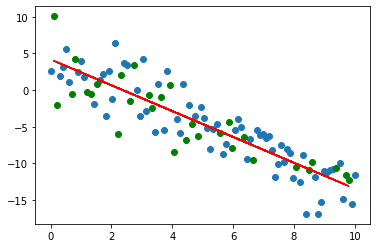

2.779361258014949 0.7299607615253461


In [11]:
y_pred = regressor.predict(x_test)

plt.scatter(x_train[0], y_train)
plt.scatter(x_test[0], y_test, color='green')
plt.plot(x_test[0], y_pred, color='red')

plt.show()

from sklearn.metrics import mean_squared_error, r2_score
 
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(rmse, r2)

Для сравнения результатов добавила библиотечный вариант регрессора на тех же данных.

2.84407437254858 0.7172394787622649


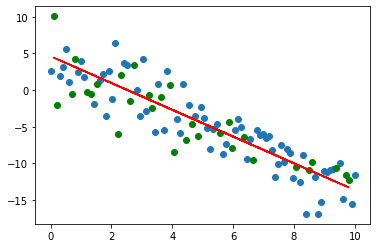

In [12]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train.T, y_train)
y_pred = reg.predict(x_test.T)

plt.scatter(x_train[0], y_train)
plt.scatter(x_test[0], y_test, color='green')
plt.plot(x_test[0], y_pred, color='red')

rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(rmse, r2)

Визуализируем падение значения функции ошибки с увеличением числа итераций.

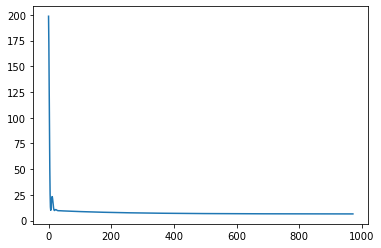

In [13]:
path = regressor.get_fit_path()

n_iterations = np.arange(len(path))
plt.plot(n_iterations, path[:, 1])

Попробуем отключить модификации градиентного спуска для регрессора и установить learning_rate = 1.

In [14]:
regressor.fit(x_train, y_train, learning_rate=1, use_momentum=False)
y_pred = regressor.predict(x_test)

path = regressor.get_fit_path()

print(path)

[[array([1., 1.]) 198.69932432081092]
 [array([-163.84948988,  -21.45289837]) 987267.2064259808]
 [array([11740.52166355,  1732.75221693]) 5164960227.435223]
 [array([-849311.77001785, -125077.47309602]) 27021069539845.984]
 [array([61430496.07881246,  9047130.56381947]) 1.4136376039205146e+17]
 [array([-4.44326087e+09, -6.54377604e+08]) 7.395603909281831e+20]
 [array([3.21380550e+11, 4.73310575e+10]) 3.869093254968341e+24]
 [array([-2.32454183e+13, -3.42344996e+12]) 2.0241595952500393e+28]
 [array([1.68133844e+15, 2.47617743e+14]) 1.0589618282737221e+32]
 [array([-1.21611017e+17, -1.79101630e+16]) 5.540077750649402e+35]
 [array([8.79611092e+18, 1.29544004e+18]) 2.898353903206708e+39]
 [array([-6.36221695e+20, -9.36990295e+19]) 1.5163063997159372e+43]
 [array([4.60178423e+22, 6.77724007e+21]) 7.932727246578526e+46]
 [array([-3.32846526e+24, -4.90196997e+23]) 4.150095362019061e+50]
 [array([2.40747511e+26, 3.54558927e+25]) 2.1711690038606485e+54]
 [array([-1.74132399e+28, -2.56452065e+2

C:\Users\alezi\anaconda3\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-7-f74969a376ac>:23: RuntimeWarning: overflow encountered in square
  return np.square(self.r(params)).mean()
<ipython-input-6-bf46ce3874ab>:5: RuntimeWarning: invalid value encountered in multiply
  result += params[i] * column


Наташ, мы всё опрокинули... Совсем всё.

Значение функции ошибок взлетело до небес и привело к переполнению в ходе спуска, т.к. ограничение по области определения MSE я намеренно убрала из оптимизатора, а максимальное число итераций оставила достаточно большим.

По моим соображениям это происходит, потому что при большом значении learning_rate мы делаем шаг слишком большой длинны. MSE в случае линейной регрессии будет фунцией степени 2. Тогда для понимания, проще всего представить себе двумерный случай, где она будет выглядеть, как параболоид. 

Очевидно, у неё будет один минимум, но при чрезмерно больших шагах мы будем прыгать с одной стенки параболоида на противоположную и не сможем спуститься вниз. Более того, делая такой большой шаг, мы рискуем попасть в точку с бОльшим значением MSE, как это получилось выше. Тогда значение антиградиента увеличится. В купе с большим значением learning rate следующий шаг снова увеличит значение функции и т.д.